## A machine learning model to predict district median housing prices in California

In [8]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### The dataset
The dataset is downloaded from Kaggle under California Housing 1990 dataset. (https://www.kaggle.com/camnugent/california-housing-prices)

In [34]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

%matplotlib inline

In [23]:
housing_csv = open("housing.csv","r")
housing_df = pd.read_csv(housing_csv)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [37]:
# to find the size of the dataset in bytes

sys.getsizeof(housing_df)

2829172

In [38]:
# info() can give a sneak peak in to pandas DataFrame

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [32]:
# to find out the type of categories for a categorical attribute (here ocean_proximity)

housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [33]:
# describe() method shows a summary of the numerical attributes

housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Drawing histograms to observe the trend in data

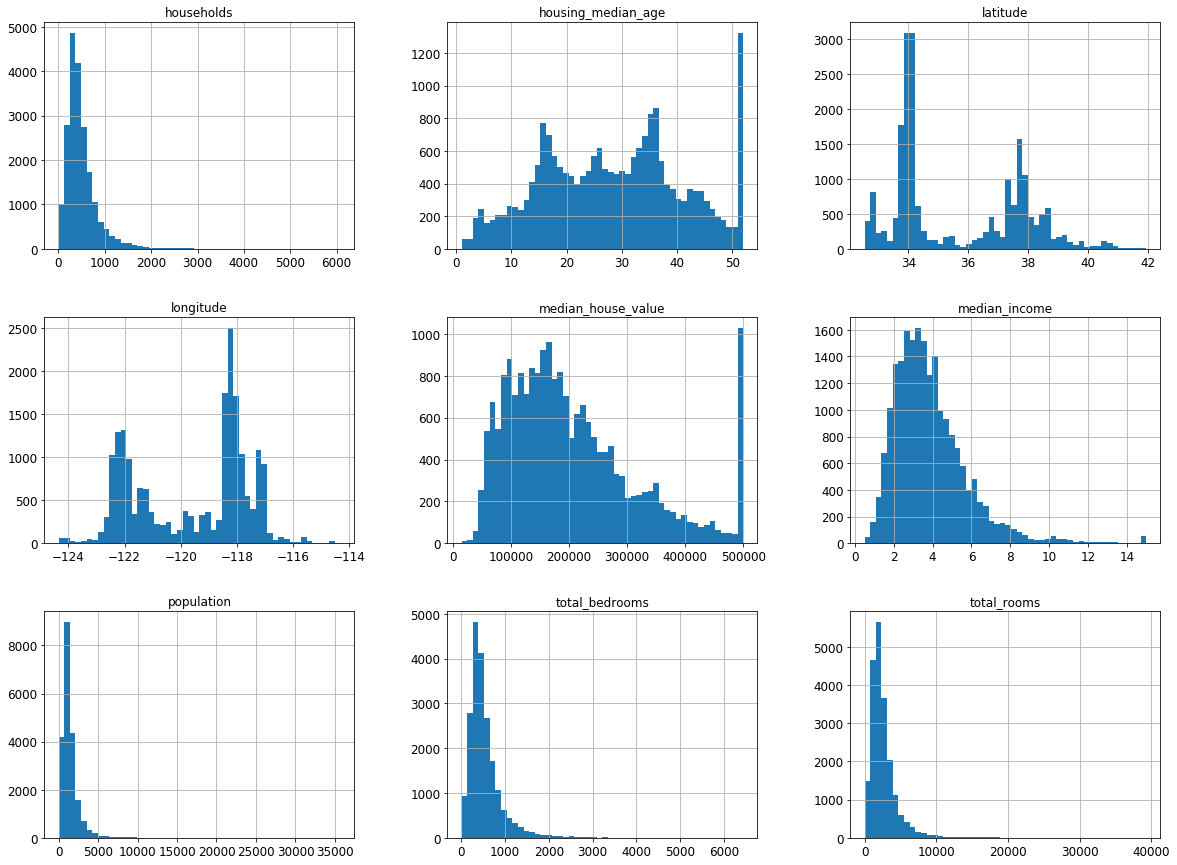

In [42]:
housing_df.hist(bins=50, figsize=(20,15))
plt.show()

#### A few observations obtained from the histograms

The median_income is not in USD. Upon further inquiry, it is found that the feature was scaled as follows: the maximum income households were set at 15 and minimum at 0.5. 
Housing median age and median house value attribute were also scaled. It can be deduced from the histogram which shows these two features have sharp peaks at the maximum abscissa. Since house value is the target label, the model may think that its value never goes beyond 500,000 (as shown in the graph above). There are two ways this issue can be addressed:
1. Collect proper labels for the districts whose labels were capped.
2. Remove the districts with values above 500,000 from the training as well as test dataset.

Many histograms are *tail heavy*, meaning they extend much farther to the right then to the left. Normalization using Gaussian distribution could be used to obtain a bell shaped curve. 

In [61]:
# splitting the data into training and test datasets

from sklearn.model_selection import train_test_split

X_np = housing_df.values
X = X_np[:,0:7]
y = X_np[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("X shape, y shape: \n", X_train.shape, y_train.shape, X_test.shape)


X shape, y shape: 
 (14448, 7) (14448,) (6192, 7)


### Stratified Sampling

A sampling method based on proportional random sampling to reflect the true proportion of the population in the sample. To reduce the sampling bias, we will use stratified random sampling by choosing a particular attribute.

In this project, median house income could serve as an important attribute in deciding the price of the house. Stratified random sampling works better with fewer categories. Here, income is a continuous variable and it will generate numerous strata if we do not convert it in to few reasonable categories. 



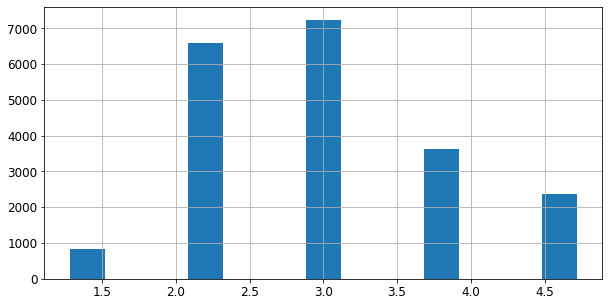

In [73]:
# the following code divides the incomes by 1.5, uses ceil to round of to integers and creates five categories of 
# sample

housing_df["income_cat"] = np.ceil(housing_df["median_income"] / 1.5)
housing_df["income_cat"].where(housing_df["income_cat"] < 5, 5.0, inplace=True)

income = housing_df["income_cat"]
income.hist(bins=5, figsize=(10,5), rwidth=.3)
plt.show()

### Applying StratifiedShuffleSplit in sklearn

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]
    
# to see if the stratified random sampling worked or not

print(housing_df["income_cat"].value_counts() / len(housing_df))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350614
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039890
Name: income_cat, dtype: float64
3.0    0.350568
2.0    0.318868
4.0    0.176287
5.0    0.114480
1.0    0.039798
Name: income_cat, dtype: float64


    It can be seen from above table that there are ~35% in 3.0 income group, and ~32% in 2.0 etc in parent dataset. It can also be seen that train and test datasets represent the proportional sampling after stratified sampling method was applied.

### Deleting the income_cat attribute which has served its purpose of giving us proportional and stratified trained and test datasets

In [81]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Looking at the dataset (training) in depth

In [83]:
# creating a copy of the dataset to play around

housing = strat_train_set.copy()

    Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

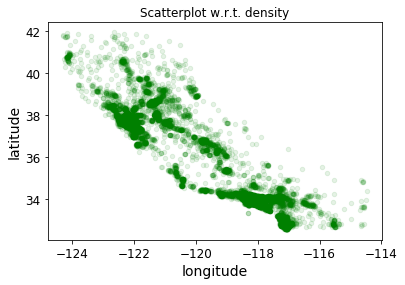

In [92]:
# Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data
# points

housing.plot(kind="scatter", title="Scatterplot w.r.t. density", x="longitude", y="latitude", alpha=0.1, color="green")


Now let’s look at the housing prices. The radius of each circle in the figure below represents the district’s
population (called s here), and the color represents the price (called c here). We will use a predefined color map
(option cmap) called jet, which ranges from blue (low values) to red (high prices).

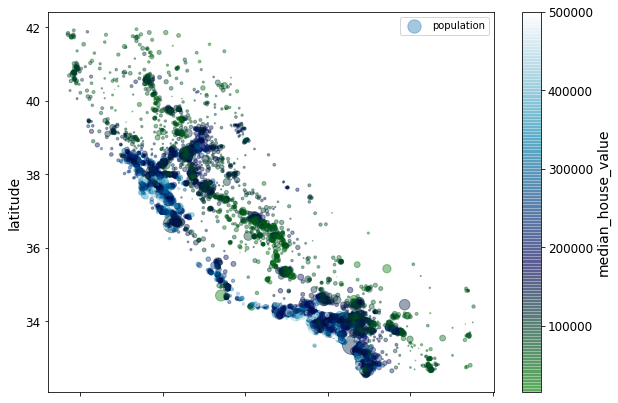

In [98]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("ocean"), colorbar=True
            ) 
plt.legend()

### *Correlation Coefficient*
Pearson's r is a numerical summary of the strength of the **linear** association between the variables. If the variables tend to go up and down together, the correlation coefficient will be positive. If the variables tend to go up and down in opposition with low values of one variable associated with high values of the other, the correlation coefficient will be negative.

We will use the default correlation function (corr()) of pandas to calculate Pearson's r correlation coefficient.

In [103]:
corr_coeff_matrix = housing.corr()
corr_coeff_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689704
total_rooms           0.136794
housing_median_age    0.115673
households            0.069646
total_bedrooms        0.053276
population           -0.023654
longitude            -0.050885
latitude             -0.138676
Name: median_house_value, dtype: float64

### Plotting correlation coefficients between numerical attributes

pandas has default scatter plotting method called scatter_matrix that will draw scatter plots between each numerical attribute choosing two at a time. i.e. if we have 11 features, we will have 11<sup>2</sup> = 121 possible scatter plots. 

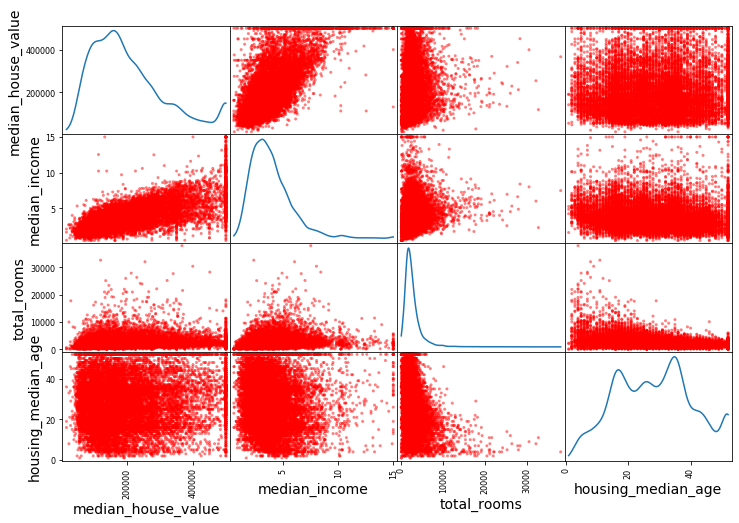

In [114]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='kde', color='red')
plt.show()

    The most important attribute seems to be median_income.

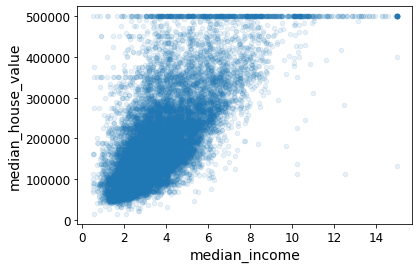

In [115]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

    Trying some feature engineering

In [119]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.689704
rooms_per_household         0.152694
total_rooms                 0.136794
housing_median_age          0.115673
households                  0.069646
total_bedrooms              0.053276
population                 -0.023654
population_per_household   -0.026068
longitude                  -0.050885
latitude                   -0.138676
bedrooms_per_room          -0.256251
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms
A better way is to write functions to achieve this task. This will not only provide a book-keeping resource but also help in future studies.

In [123]:
# dropping the target label from the training dataset

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [126]:
housing_labels.tail()

8519     242000.0
13664    151600.0
964      339700.0
14839     97800.0
2724      61000.0
Name: median_house_value, dtype: float64

### Getting rid of missing values
Three possible ways to remove the missing values from the data:

1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the values to some value (zero, the mean, the median, etc.).

These tasks can be achieved in pandas DataFrames as follows:

1. housing.dropna(subset=["total_bedrooms"]) # option 1
2. housing.drop("total_bedrooms", axis=1) # option 2
3. median = housing["total_bedrooms"].median() # option 3a
4. housing["total_bedrooms"].fillna(median, inplace=True) # option 3b

In [127]:
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values in any of the attributes: *Imputer*. Here is how to use it. First,
you need to create an Imputer instance, specifying that you want to replace each attribute’s missing
values with the median of that attribute:

In [130]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# Since median can only be filled in the numerical columns/attributes, we will create a copy without last feature

housing_num = housing.drop("ocean_proximity", axis=1)

# Now imputer instance can be applied on the DataFrame
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [132]:
# statistics_ stores the median for each attribute

imputer.statistics_

array([-118.48  ,   34.24  ,   29.    , 2136.    ,  437.    , 1168.    ,
        410.5   ,    3.5391])

In [134]:
# Now the imputer can be applied to the training dataset which returns a plain NumPy array containing the transformed 
# features

X = imputer.transform(housing_num)

# converting it back into pandas DataFrame

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### LabelEncoder to transform text into numbers
*fit_transform()* is equivalent to calling *fit()* and then *transform()*

In [135]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 0, 0, ..., 0, 4, 1])

In [136]:
# classes_ attribute can show the mapping of the encoder

print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue with this representation is that ML algorithms will assume that two nearby values are more
similar than two distant values. Obviously this is not the case (for example, categories 0 and 4 are more
similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per
category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another
attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot
encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).
Scikit-Learn provides a OneHotEncoder encoder to convert integer categorical values into one-hot
vectors. Let’s encode the categories as one-hot vectors. Note that fit_transform() expects a 2D array,
but housing_cat_encoded is a 1D array, so we need to reshape it.

In [143]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<14448x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14448 stored elements in Compressed Sparse Row format>

We can apply both transformations (from text categories to integer categories, then from integer categories
to one-hot vectors) in one shot using the *LabelBinarizer* class which return NumPy array by default which would be memory inefficient to store a lot of zeros. sparse_output=True can be passed as argument in the encoder to get a SciPy sparse matrix instead. 

In [144]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

### Custom Transformers
Following is an example of a custom transformer.

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling
Feature scaling is very important for the increased accuracy of the model.
Sklearn provides Pipeline and Preprocessing classes to do feature scaling.

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', Imputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)